 ## Automating the Job Search

For dedicated job seekers, the job hunt is a full time job. It not only requires applying to jobs, but also networking, self-promotion through social media, and other time-consuming tasks. It takes a massive amount of time to click and scroll through job descriptions, trudge through application forms, and get little to no return of time investment. Today I want to ease the burden of going to various job sites through automation. 

It's about understanding the value of your time when potential employers don't. 

What this component does is consolidate job posts from various job sites into a single database. There's no need to crawl through pages and wait for sites to load.

In [216]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# other 
import os
import warnings
warnings.filterwarnings("ignore")
import requests
from bs4 import BeautifulSoup 

In [217]:
country = [
    "Latvia" 
     ]

In [218]:
cities = [
    "Riga",
    "Jelgava"
     ]

In [219]:
it_job=[
    "Data%20Engineer",
    "Data%20Analyst",
    "Data%20Scientist",
    "machine%20learning",
    "web%20dizainer",
    "soft%20developer"
]

Past_month="f_TPR=r2592000"
Past_week="f_TPR=r604800"
Past_24_hours="f_TPR=r86400"

onsite="f_WT=1"
remote="f_WT=2"
hybrid="f_WT=3"

internship="f_E=1"
entry_level="f_E=2"
associate="f_E=3"
mid_senior="f_E=4"
director="f_E=5"
Executive="f_E=6" 

In [220]:
def extract_description():
    request = requests.get("https://www.linkedin.com/jobs/view/3691414587")
    data = request.text 
    soup = BeautifulSoup(data)
    soup

    job_description_div = soup.find('div', class_='description__text description__text--rich')

    # Extract the text content from within the <div> tag
    job_description = job_description_div.get_text(strip=True)
    return(job_description)

In [221]:
!pip install transformers flair

In [222]:
from flair.models import SequenceTagger
from flair.data import Sentence  # Import the Sentence class from flair.data

def get_skills(input_text):
    # Create a Sentence object
    sentence = Sentence(input_text)

    # Use the loaded Flair model to predict entities
    flair_model.predict(sentence)
    description=[]
    # Extract and print named entities
    for entity in sentence.get_spans("ner"):
        description.append(entity.text)
        
    return(description)

In [223]:
from datetime import datetime

# Get today's date
today_date = datetime.today().date()

# Convert the date to a string
today_date_string = today_date.strftime('%Y-%m-%d')

In [224]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time

import re
import traceback
import time

# Load the pre-trained Flair NER model
flair_model = SequenceTagger.load("kaliani/flair-ner-skill")


def scrape_jobs(location0, position): 
    level_mapping = {
        "internship": "f_E=1",
        "entry_level": "f_E=2",
        "mid_senior": "f_E=4"
    }

    work_type_mapping = {
        "onsite": "f_WT=1",
        "hybrid": "f_WT=3"
    }
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    job_data=[]
    
    for WorkType1,WorkType2 in work_type_mapping.items():
        for levelMapping1,levelMapping2 in level_mapping.items():
            url_basic = "https://www.linkedin.com/jobs/search/?location="+location0+"&keywords="+position+"&"+levelMapping2+"&"+WorkType2+"&f_TPR=r86400"
            
            k=-25
            
            url = url_basic +"&start="+str(0)


            # Send a GET request with headers
            request = requests.get(url, headers=headers)
            data = request.text
            soup = BeautifulSoup(data)

            try:
                titletag=soup.find('title')
                if titletag is not None:
                    input_string=str(titletag.get_text()).split(" ")[0]
                    digits_only = re.sub(r'\D', '', input_string)
                    nbre_offers=int(digits_only)
                else:
                    nbre_offers=230
                nbre_pages=(int(nbre_offers/25))*25
                while(k<=nbre_offers):
                    k=k+25
                    locations = []
                    titles = []
                    countries = []    
                    links = []
                    job_description=[]
                    company_name = []
                    skills = []
                    datelist = []
                    job_description=[]
                    url = url_basic +"&start="+str(k)
                    request = requests.get(url)
                    data = request.text
                    soup = BeautifulSoup(data)
                    #print(url)
                    

                    job_links = soup.findAll("a",{"class":"base-card__full-link"})  
                    title = soup.findAll("h3",{"class":"base-search-card__title"})
                    location = soup.findAll("span", {"class":"job-search-card__location"})
                    country = soup.findAll("span", {"class":"job-search-card__location"})
                    names = soup.findAll("a",{"class":"hidden-nested-link"})

                    for i in title:
                        x=i.text.replace("\n"," ").strip(" ")
                        titles.append(x) 

                    for i in location:
                        x=i.text.replace("\n"," ").strip(" ")
                        locations.append(x)   
                    for i in country:
                        x=i.text.replace("\n"," ").strip(" ").split(',')[-1]
                        countries.append(x)

                    for i in job_links:
                        x=str(i["href"].split("?refId=")[0])
                        links.append(x)
                        
                        request = requests.get(x, timeout=230,headers=headers)
                        data = request.text 
                        soup = BeautifulSoup(data)


                        job_description_div = soup.find('div', class_='description__text description__text--rich')
                        
                        if job_description_div is not None:
                            job_description.append(job_description_div.get_text())
                            skills.append(get_skills(str(job_description_div.get_text())))
                        else:
                            skills.append("No skills extracted")
                            job_description.append("No job description available")
                        
                    for i in names:
                        x=i.text.replace("\n"," ").strip(" ")
                        company_name.append(x)
                    
                    for j in range(len(job_links)):
                        job_data.append({
                            "position":position.replace("%20"," "),
                            "date":today_date_string,
                            "WorkType":WorkType1,
                            "levelMapping":levelMapping1,
                            "Title": titles[j],
                            "Company": company_name[j],
                            "Location": locations[j],
                            "Link": links[j],
                            "job description":job_description[j],
                            "skills":skills[j]
                        })

                    if len(job_links)==0:
                        break    
            except Exception as error:
                print(error)
                print(url)
                pass
            
    job_df = pd.DataFrame(job_data)


    return(job_df)


result_df=[]

for location in country+cities:
    for position in it_job:
        result_df.append(scrape_jobs(location, position))
        
combined_df = pd.concat(result_df)
#combined_df = combined_df.drop_duplicates(subset=['Title','Link','description'])
combined_df = combined_df.drop_duplicates(subset=['position','Title','Company','Location'])

# Reset the index if needed
combined_df = combined_df.reset_index(drop=True)

2025-01-10 12:33:03,818 SequenceTagger predicts: Dictionary with 7 tags: O, S-SKILL, B-SKILL, E-SKILL, I-SKILL, <START>, <STOP>


In [225]:
combined_df.head( )

,position,date,WorkType,levelMapping,Title,Company,Location,Link,job description,skills
0,Data Engineer,2025-01-10,hybrid,entry_level,System Engineer - aerospace & defence,SII Group Belgium,"Lieģi, Liepaja, Latvia",https://lv.linkedin.com/jobs/view/system-engin...,\n\n\nSII Belgium is currently seeking a (Juni...,"[computer science, C#, Python, Java, Software ..."
1,Data Engineer,2025-01-10,hybrid,entry_level,Embedded Software Engineer (VIE),SII Group Belgium,"Lieģi, Liepaja, Latvia",https://lv.linkedin.com/jobs/view/embedded-sof...,\n\n\n The SII Group is at the heart ...,"[Design, C, C, ++ language, Python, less]"
2,Data Engineer,2025-01-10,hybrid,mid_senior,Software Lead Engineer (m/w/d),Gentherm - Morocco,"More, Sigulda Municipality, Latvia",https://lv.linkedin.com/jobs/view/software-lea...,"\n\n\nWir von Gentherm wissen, es geht immer u...","[English, less]"
3,Data Engineer,2025-01-10,hybrid,mid_senior,Site Reliability Engineer III,GoCardless,"Riga, Latvia",https://lv.linkedin.com/jobs/view/site-reliabi...,\n\n\nAbout usAt GoCardless we believe bank pa...,"[Ruby, Github, Python, Ruby, Prometheus, less]"
4,Data Analyst,2025-01-10,hybrid,entry_level,System Engineer - aerospace & defence,SII Group Belgium,"Lieģi, Liepaja, Latvia",https://lv.linkedin.com/jobs/view/system-engin...,\n\n\nSII Belgium is currently seeking a (Juni...,"[computer science, C#, Python, Java, Software ..."


In [226]:
print(combined_df.head ) 

<bound method NDFrame.head of           position        date WorkType levelMapping  \
0    Data Engineer  2025-01-10   hybrid  entry_level   
1    Data Engineer  2025-01-10   hybrid  entry_level   
2    Data Engineer  2025-01-10   hybrid   mid_senior   
3    Data Engineer  2025-01-10   hybrid   mid_senior   
4     Data Analyst  2025-01-10   hybrid  entry_level   
5     Data Analyst  2025-01-10   hybrid  entry_level   
6   Data Scientist  2025-01-10   hybrid  entry_level   
7   Data Scientist  2025-01-10   hybrid  entry_level   
8   Data Scientist  2025-01-10   hybrid   mid_senior   
9   Data Scientist  2025-01-10   hybrid   mid_senior   
10  Data Scientist  2025-01-10   hybrid   mid_senior   
11    Data Analyst  2025-01-10   hybrid   mid_senior   
12    Data Analyst  2025-01-10   hybrid   mid_senior   
13  soft developer  2025-01-10   hybrid   mid_senior   
14  soft developer  2025-01-10   hybrid   mid_senior   
15    Data Analyst  2025-01-10   hybrid   mid_senior   
16  Data Scientist

In [227]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   position         18 non-null     object
 1   date             18 non-null     object
 2   WorkType         18 non-null     object
 3   levelMapping     18 non-null     object
 4   Title            18 non-null     object
 5   Company          18 non-null     object
 6   Location         18 non-null     object
 7   Link             18 non-null     object
 8   job description  18 non-null     object
 9   skills           18 non-null     object
dtypes: object(10)
memory usage: 1.5+ KB


In [228]:
combined_df.shape

(18, 10)

In [229]:
combined_df.tail()

,position,date,WorkType,levelMapping,Title,Company,Location,Link,job description,skills
13,soft developer,2025-01-10,hybrid,mid_senior,"Senior Front End Developer (Hybrid) Riga, Latvia",Docupace,"Riga, Riga, Latvia",https://lv.linkedin.com/jobs/view/senior-front...,\n\n\nJob DescriptionWho We AreDocupace Techno...,[less]
14,soft developer,2025-01-10,hybrid,mid_senior,Site Reliability Engineer III,GoCardless,"Riga, Latvia",https://lv.linkedin.com/jobs/view/site-reliabi...,\n\n\nAbout usAt GoCardless we believe bank pa...,"[Ruby, Github, Python, Ruby, Prometheus, less]"
15,Data Analyst,2025-01-10,hybrid,mid_senior,MuleSoft Technical Lead,Cognizant,"Riga, Riga, Latvia",https://lv.linkedin.com/jobs/view/mulesoft-tec...,\n\n\n What makes Cognizant a unique ...,"[gender expression, less]"
16,Data Scientist,2025-01-10,hybrid,mid_senior,MuleSoft Technical Lead,Cognizant,"Riga, Riga, Latvia",https://lv.linkedin.com/jobs/view/mulesoft-tec...,\n\n\n What makes Cognizant a unique ...,"[gender expression, less]"
17,soft developer,2025-01-10,hybrid,mid_senior,MuleSoft Technical Lead,Cognizant,"Riga, Riga, Latvia",https://lv.linkedin.com/jobs/view/mulesoft-tec...,\n\n\n What makes Cognizant a unique ...,"[gender expression, less]"


In [230]:
combined_df.isnull()

,position,date,WorkType,levelMapping,Title,Company,Location,Link,job description,skills
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False


In [231]:
combined_df.isnull().sum() ,combined_df.isnull().sum()

(position           0
 date               0
 WorkType           0
 levelMapping       0
 Title              0
 Company            0
 Location           0
 Link               0
 job description    0
 skills             0
 dtype: int64,
 position           0
 date               0
 WorkType           0
 levelMapping       0
 Title              0
 Company            0
 Location           0
 Link               0
 job description    0
 skills             0
 dtype: int64)

In [232]:
combined_df.dtypes

position           object
date               object
WorkType           object
levelMapping       object
Title              object
Company            object
Location           object
Link               object
job description    object
skills             object
dtype: object

In [233]:
combined_df.describe().T

,count,unique,top,freq
position,18,4,Data Scientist,6
date,18,1,2025-01-10,18
WorkType,18,1,hybrid,18
levelMapping,18,2,mid_senior,12
Title,18,6,Site Reliability Engineer III,4
Company,18,5,SII Group Belgium,6
Location,18,4,"Lieģi, Liepaja, Latvia",6
Link,18,18,https://lv.linkedin.com/jobs/view/system-engin...,1
job description,18,7,\n\n\nAbout usAt GoCardless we believe bank pa...,4
skills,18,7,"[Ruby, Github, Python, Ruby, Prometheus, less]",4


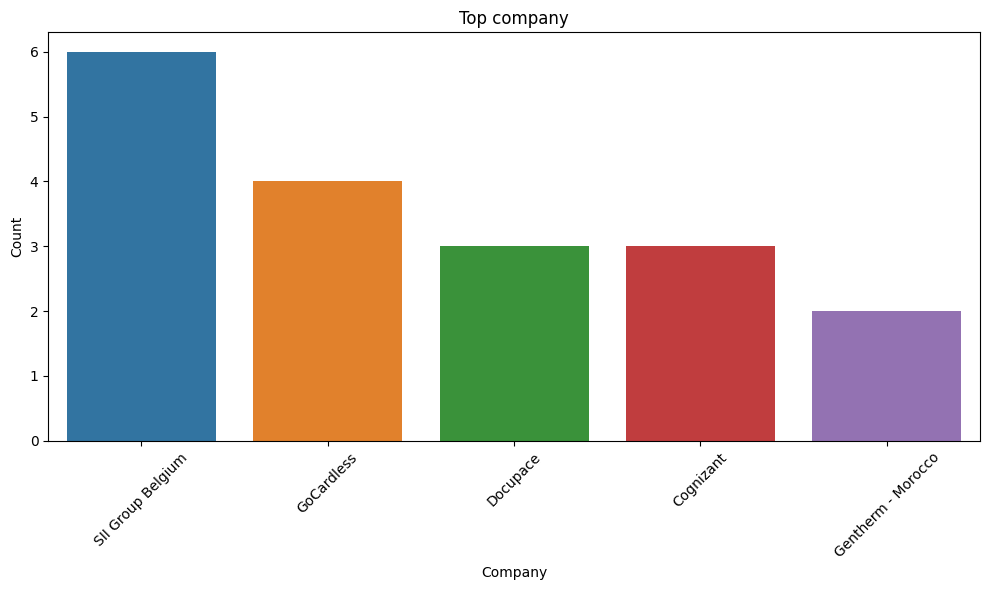

In [234]:
# Top Company
top_industries = combined_df['Company'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_industries.index, y=top_industries.values)
plt.title('Top company')
plt.xlabel('Company')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

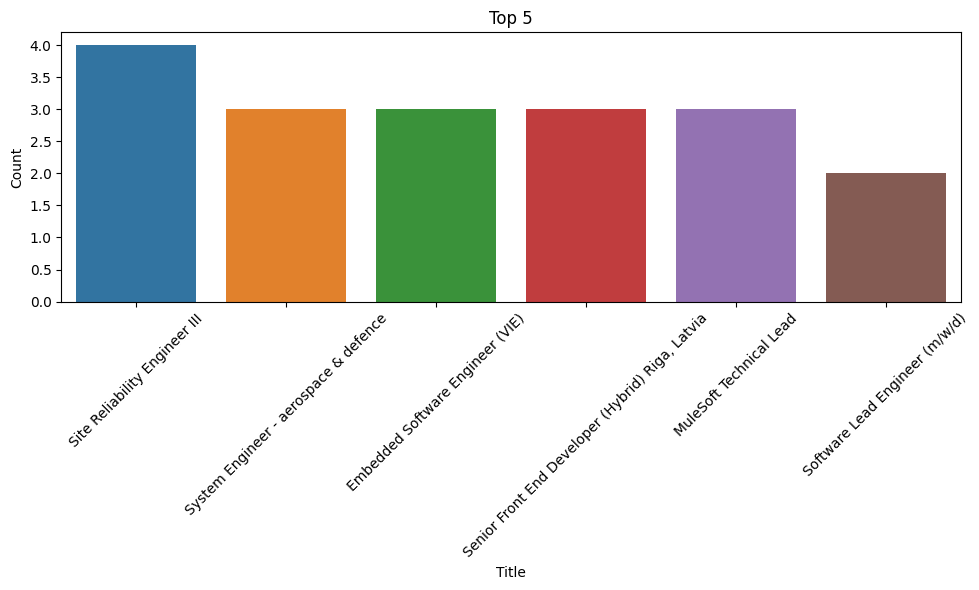

In [235]:
# Top Title
top_industries = combined_df['Title'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_industries.index, y=top_industries.values)
plt.title('Top 5')
plt.xlabel('Title')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

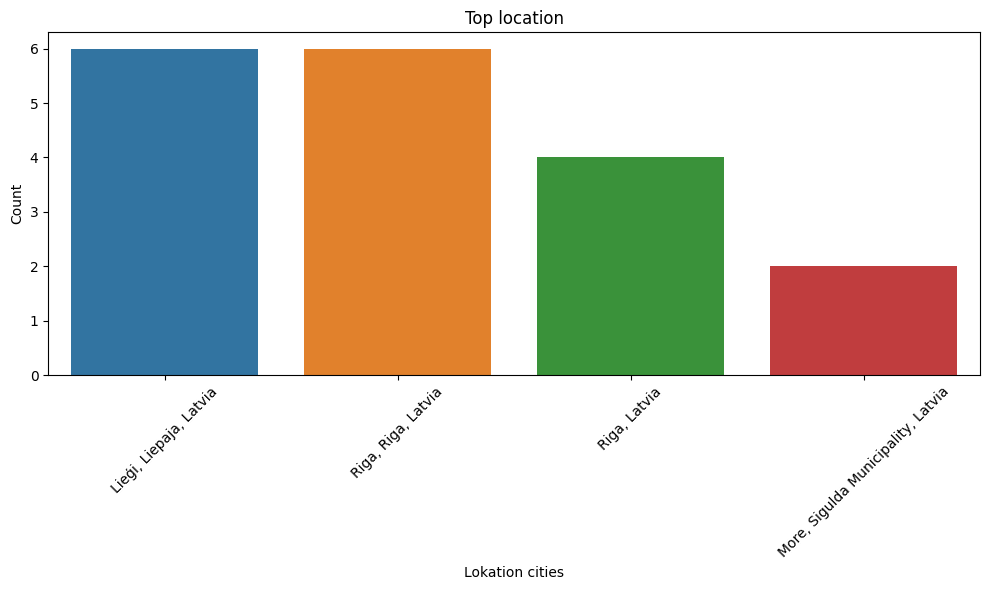

In [236]:
# Top Location
top_industries = combined_df['Location'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_industries.index, y=top_industries.values)
plt.title('Top location')
plt.xlabel('Lokation cities')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

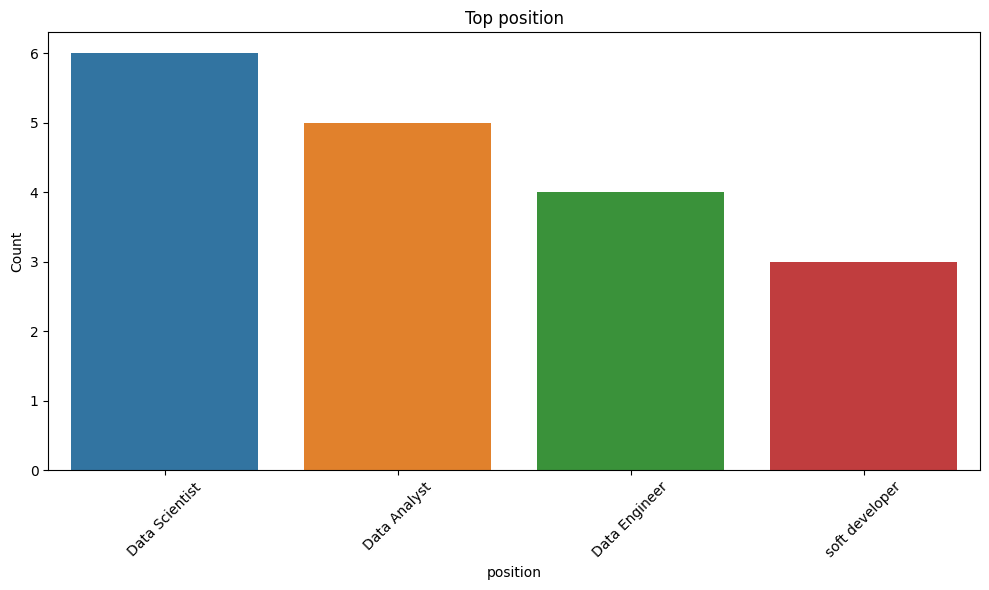

In [237]:
# Top Position
top_industries = combined_df['position'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_industries.index, y=top_industries.values)
plt.title('Top position')
plt.xlabel('position')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [238]:
combined_df.to_csv("linkedin_offers"+today_date_string+".csv")